## Preface
I found the [topic](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/43384) started by [Yang Yu](https://www.kaggle.com/popyy0101) doubting about the significance of small improvement in Gini score. **Yang Yu** wrote that:

> Several years ago, one of my tutors told me that "any improvement within 0.001 level is just noise", which means it was just randomly switching 1 label out of 1000 samples in evaluation set (roughly).

The question is very interesting at least for **Yang Yu** and me so I decided to investigate that. Since I'm not a statistician but a software engineer I decided to use my programming skills to make Gini scoring on simulated data and answer the next very specific questions:
- How much samples it is needed to be correct to improve Gini from *0.286* to *0.287*?
- What is the probability to get from *0.286* to *0.287* by just random guessing?

Also I got a bit excited what I can do and played with public/private scoring. It's cool when you can simulate 0.290! :D

I would like to repeat that I'm not a statistician and I do not pretend on ultimate truth. The experiment I provide may be wrong and contain some things I am missing. Any criticism, suggestions, hints are very welcomed. The more I'm writing the more I'm doubting whether it's not a trash :)

## Assumptions
We assume the next things:
- Imbalance of positive and negative classes in the test set is the same as in the training set.
- Our model outputs uniformly distributed probabilities.
- Public and private leaderboard scores are independent from each other. 

In [1]:
import pandas as pd
train = pd.read_csv("../input/train.csv")
counts = train.target.value_counts()
print("Class distribution:")
counts / counts.sum()

Class distribution:


0    0.963552
1    0.036448
Name: target, dtype: float64

Appoximately 96.4% of the data are negative class labels. Let's create perfect submission(oh, here we can!) and target vector that correspond to the test data size. 

In [2]:
import numpy as np
test = pd.read_csv("../input/train.csv")
length = len(test)
np.random.seed(287)
perfect_sub = np.random.rand(length)
target = (perfect_sub > 0.963552).astype(dtype=int)
print("Perfect submission looks like: ", perfect_sub)
print("Target vector looks like: ", target)
print("Target vector class distibution: ")
counts = pd.Series(target).value_counts()
counts / counts.sum()

Perfect submission looks like:  [ 0.14448523  0.71075312  0.87616033 ...,  0.3776089   0.76920165
  0.64545703]
Target vector looks like:  [0 0 0 ..., 0 0 0]
Target vector class distibution: 


0    0.963845
1    0.036155
dtype: float64

Almost the same imbalance we have in the training set.
Now let's define Normalized Gini Score. [Sklearn](http://scikit-learn.org/stable/index.html) package has [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) and we are going to compute Normalized Gini with *AUC* using the next formula:
\begin{align}
Gini & = 2 * AUC - 1
\end{align}
Let's see how our perfect submission is evaluated by Gini. Hold your breath!


In [3]:
from sklearn.metrics import roc_auc_score
def gini(y_target, y_score):
    return 2 * roc_auc_score(y_target, y_score) - 1
print(f"Gini on perfect submission: {gini(target, perfect_sub):0.5f}")

Gini on perfect submission: 1.00000


Amazing! This is the highest score we can get from Gini and probably will never see on the leaderboard. Let's  also define completely random submission and test it.

In [4]:
np.random.seed(8888)
random_sub = np.random.rand(length)
print(f"Gini on random submission: {gini(target, random_sub):0.5f}")

Gini on random submission: 0.00078


Almost zero. That's what we expect from Gini when we have no idea about the data and use guessing.

We know that the public leaderboard is calculated on approximately 30% of the test data. So we should create private and public sets. Our generated answers are randomly distributed and we can just subset first 30% for public dataset and the rest 70% for private dataset. We also create function that evaluates public and private score.

In [5]:
first30percent = int(length * 0.3)
target_pub = target[:first30percent]
target_prv = target[first30percent:]

def evaluate(submission):
    return gini(target_pub, submission[:first30percent]),\
        gini(target_prv, submission[first30percent:])

Let's define **spoiler** function. It fills our perfect submission with *n* randomly distributed random answers i.e. imputes the error in the result. Also we will spoil our perfect submission an look how Gini changes. The calculations take some time, let's respect Kaggle for calculating our sometimes trashy submissions.

In [6]:
def spoiler(n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    tospoil = np.random.choice(range(length), size=n, replace=False)
    submission = perfect_sub.copy()
    submission[tospoil] = np.random.rand()
    return submission

submissions = []
for spoil_n in range(0, length, 5000):
    score_pub, score_priv = evaluate(spoiler(spoil_n, spoil_n))
    submissions.append((spoil_n, score_pub, score_priv))
submissions = pd.DataFrame(submissions, columns = ["n", "public_score", "private_score"])
submissions.head()

,n,public_score,private_score
0,0,1.000000,1.000000
1,5000,0.982766,0.986919
2,10000,0.970603,0.970982
3,15000,0.951957,0.946309
4,20000,0.995440,0.995725


The chart showing dependence between number of spoiled samples and Gini is the following:

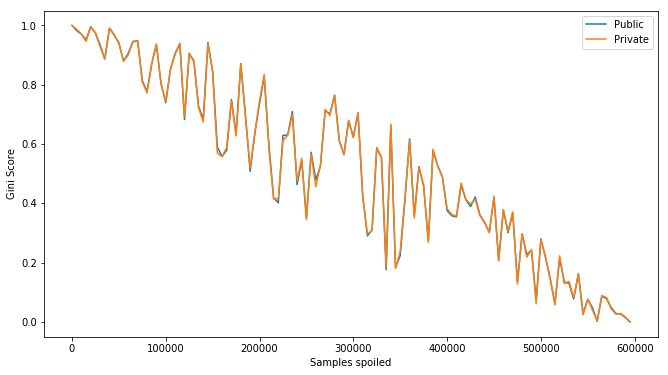

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,6))
plt.plot(submissions["n"], submissions["public_score"], label="Public")
plt.plot(submissions["n"], submissions["private_score"], label = "Private")
plt.xlabel("Samples spoiled")
plt.ylabel("Gini Score")
_ = plt.legend()

Let's plot the distribution of difference between public score and private score.

count    120.000000
mean       0.000419
std        0.006126
min       -0.015548
25%       -0.002708
50%       -0.000089
75%        0.003982
max        0.023366
dtype: float64

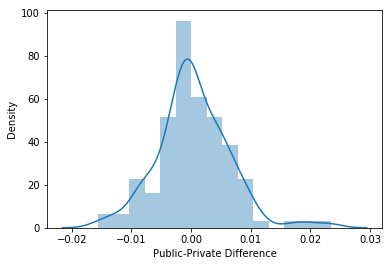

In [8]:
import seaborn as sns
pub_prv_diff = submissions["public_score"] - submissions["private_score"]
_ = sns.distplot(pub_prv_diff, hist=True)
_ = plt.xlabel("Public-Private Difference")
_ = plt.ylabel("Density")
pub_prv_diff.describe()

Public score seems to be usually higher than a private score(slightly left-skewed distribution).
Let's see inverse cumulative plot of absolute difference.

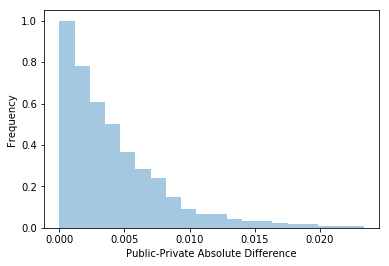

In [9]:
_ = sns.distplot(abs(pub_prv_diff), bins=20,
             hist_kws=dict(cumulative=-1),
             kde_kws=dict(cumulative=True), kde=False, norm_hist=True)
_ = plt.xlabel("Public-Private Absolute Difference")
_ = plt.ylabel("Frequency")

It says the absolute difference more than *0.005* appears in every third case. It is a lot!
But this has nothing to do with guessing. It just tells us we should expect difference in public-private outcome.
I manually found the submission where the public Gini score is close to *0.286*. It required predicting more that *170000* samples like in the perfect submission.

In [10]:
np.random.seed(123)
correct = 172560
index = np.random.choice(range(length), size=(length-correct), replace=False)
submission286 = perfect_sub.copy()
spoiled_samples = np.random.rand(length-correct)
submission286[index] = spoiled_samples
public, private = evaluate(submission286)
print(f"Public score: {public:0.4f}\nPrivate score: {private:0.4f}")

Public score: 0.2862
Private score: 0.2896


We should steadily add correct samples to our *submission286* in order to get 0.287. Sounds easy, doesn't it?
We will steadily increase number of correct answers from 5 to infinity with step 5 and give 30 tries for each addition because our correct samples are selected in a random order. We will stop when we reach 0.287.

In [11]:
tries, fix = 30, 0
found = False
np.random.seed(10)
while not found:
    fix += 5
    print(f"Fixing {fix} samples")
    for t in range(tries):
        new_submission = submission286.copy()
        improve_index = np.random.choice(index, size=fix, replace=False)
        new_submission[improve_index] = perfect_sub[improve_index]
        public, _ = evaluate(new_submission)
        if public >= 0.287:
            print("0.287 reached!")
            found = True
            break

Fixing 5 samples
Fixing 10 samples
Fixing 15 samples
Fixing 20 samples
Fixing 25 samples
Fixing 30 samples
Fixing 35 samples
Fixing 40 samples
Fixing 45 samples
Fixing 50 samples
Fixing 55 samples
Fixing 60 samples
Fixing 65 samples
Fixing 70 samples
Fixing 75 samples
Fixing 80 samples
Fixing 85 samples
0.287 reached!


**It takes at least 85 samples to predict correctly to reach 0.287 in my dataset**. Now let's see if it is hard to predict 85 samples correctly by simple guessing. However guessing exactly *that* 85 samples may be a hard work if we don't know indexes. So it would be more fair to make guesses with variable number of samples. Since it is a time-consuming operation I decided to check only some certain number of samples to guess.

In [12]:
# fix_samples contains number of samples to guess
fix_samples = [85, 100, 150, 200, 250, 500, 1000, 2000, 3000, 4000, 
               6000, 7000, 10000, 20000, 30000, 40000, 50000, 60000,
              100000, 200000, 300000, 500000]
# Number of tries for each group of samples
tries = 300
scores, types = [], []
np.random.seed(888)
for fix in fix_samples:
    goal_counter = 0
    # Let's guess and repeat!
    for i in range(tries):
        new_submission = submission286.copy()
        guess = np.random.choice(range(length), size=fix, replace=False)
        new_submission[guess] = np.random.rand()
        public, _ = evaluate(new_submission)
        if public >= 0.287:
            goal_counter += 1
        scores.append(public)
        types.append(fix)
    print(f"Frequency(score>=0.287 | Guessed={fix} samples, Tries={tries} times) = " + 
          f"{goal_counter/tries:0.3f}")
try_history = pd.DataFrame({"type": types, "score": scores})
print("Done!")

Frequency(score>=0.287 | Guessed=85 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=100 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=150 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=200 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=250 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=500 samples, Tries=300 times) = 0.000
Frequency(score>=0.287 | Guessed=1000 samples, Tries=300 times) = 0.003
Frequency(score>=0.287 | Guessed=2000 samples, Tries=300 times) = 0.030
Frequency(score>=0.287 | Guessed=3000 samples, Tries=300 times) = 0.010
Frequency(score>=0.287 | Guessed=4000 samples, Tries=300 times) = 0.020
Frequency(score>=0.287 | Guessed=6000 samples, Tries=300 times) = 0.033
Frequency(score>=0.287 | Guessed=7000 samples, Tries=300 times) = 0.020
Frequency(score>=0.287 | Guessed=10000 samples, Tries=300 times) = 0.017
Frequency(score>=0.287 | Guessed=20000 samples, Tries=300 times) = 0.0

Well, we see that **guessing sometimes works in order to get +0.001**! But it works extremely rarely. The best performance on guessing we achieved when our guesses touched ~2K-6K samples. For example, when we guessed 6K samples - we got 10 hits of 0.287 out of 300 tries. Is it feasable to achieve this when probing the leaderboard by the crowd? I believe yes. 

Now let's see the results on the plot.

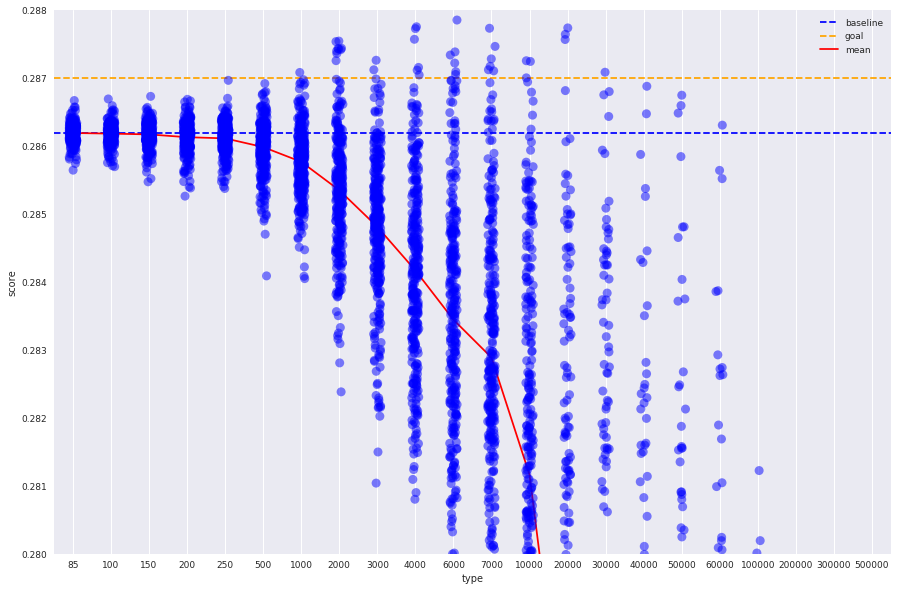

In [13]:
sns.set(font_scale=0.9)
plt.figure(figsize=(15, 10))
ax = sns.stripplot(x="type", y="score", data=try_history, jitter=True, size=9, color="blue", alpha=.5)
ax.set_ylim(0.280, 0.288)
plt.axhline(0.2862, label="baseline", color="blue", linestyle="dashed")
plt.axhline(0.287, label="goal", color="orange", linestyle="dashed")
# Draw means for each group
mean = try_history.groupby("type")["score"].agg(["mean"])["mean"]
plt.plot(range(len(fix_samples)), mean, color="red")
plt.legend()
plt.grid()

The more samples we guess - the less our expected score and the larger the variance of our results. I would recommend to stay at 6K - the optimal number :-)

# Instead of a Smart Conclusion
Please do not consider the analysis as exactly applicable to the current leaderboard. This is just a testing of the particular random example.

I learned something... and you?